In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import csv
import time
import matplotlib.pyplot as plt
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing


In [3]:
class Mydataset(Dataset):
    
    def __init__(self, x, y=None):
        self.x = torch.FloatTensor(x)
        self.y = y
        if y is not None:
            self.y = torch.FloatTensor(y)
    
    def __getitem__(self, index):
        if self.y is None:
            return self.x[index]
        else:
            return self.x[index], self.y[index]
  
    def __len__(self):
        return len(self.x)

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
        )
  
    def forward(self, x):
        return self.net(x).squeeze(1)


In [29]:
def work(path, name, windows, num_epoch, lr, ax1, ax2, xu, need_save = True):
    df = pd.read_csv(path)
    x = df.iloc[:, 1].values
    
    x = x[np.isnan(x)==False]
    n = len(x)
    data = np.zeros((n - windows, windows), dtype=float)
    y = np.zeros((n - windows, 1), dtype = float)
    for i in range(n - windows):
        data[i, :] = x[i: i + windows]
        y[i] = x[i + windows]
    
    x = data
    x = (x - x.min()) / (x.max() - x.min())
    
    bestfeatures = SelectKBest(score_func=f_regression, k=windows)
    fit = bestfeatures.fit(x, y)

    df_scores = pd.DataFrame(fit.scores_)
    df_scores.columns = ["Score"]


    best = df_scores.nlargest(windows,'Score')
    print(best)
    target = list(best.index) # 选择特征
    tmp = np.concatenate((x, y), axis=1)
    
    
    n = int(len(x) * 0.5)
    np.random.shuffle(tmp)
    valid_x, valid_y = tmp[:n, :-1], tmp[:n, -1]
    train_x, train_y = tmp[n:, :-1], tmp[n:, -1]
    
    train_set = Mydataset(train_x, train_y)
    valid_set = Mydataset(valid_x, valid_y)

    batch_size = 32
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
    
    model = Net(windows).cuda()
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss_lis = []
    valid_loss_lis = []
    
    for epoch in range(num_epoch):
        epoch_start_time = time.time()
        train_loss = 0.0
        valid_loss = 0.0
        model.train()  # 启用 batch normalization 和 drop out

        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            train_pred = model(data[0].cuda())

            batch_loss = loss(train_pred, data[1].cuda())
            batch_loss.backward()
            optimizer.step()
            train_loss += batch_loss.item()

        model.eval()
        with torch.no_grad():  # 被包住的代码不需要计算梯度
            for i, data in enumerate(valid_loader):
                valid_pred = model(data[0].cuda())
                batch_loss = loss(valid_pred, data[1].cuda())
                valid_loss += batch_loss.item()
            print('[%03d/%03d] %2.2f sec(s) Train Loss: %3.6f | Valid loss: %3.6f' %
                (epoch + 1, num_epoch, time.time() - epoch_start_time,
                  train_loss / train_set.__len__(),
                  valid_loss / valid_set.__len__())
                  )
            train_loss_lis.append(train_loss / train_set.__len__())
            valid_loss_lis.append(valid_loss / valid_set.__len__())
    
    # if need_save:
        # torch.save(model, "./"+name+"_model.pkl")
        # print("saving model completed!")

    # Loss curve
    ax1.grid(b=True, axis='y', ls=':')
    ax1.plot(train_loss_lis, linewidth=2)
    ax1.plot(valid_loss_lis, linewidth=2)
    
    ax1.set_title(xu[0] + " " + name + " learning curve", fontsize=15)
    
    ax1.set_ylabel('MSELoss', fontsize=12)
    ax1.set_xlabel('epoch', fontsize=12)
    ax1.legend(['train', 'validation'], fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # plt.savefig("loss_"+name+".png")
    
    
    model = torch.load("./"+name+"_model.pkl")
    test_set = Mydataset(x)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    ans = []
    
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data.cuda())
            for pred in test_pred:
                ans.append(pred.cpu().data.numpy()) 
                
    ax2.grid(b=True, axis='y', ls=':')
    ax2.plot(y, linewidth=2)
    ax2.plot(ans, linewidth=1.25)
    ax2.set_title(xu[1] + " " + name + " prediction", fontsize=15)
    ax2.set_ylabel('USD', fontsize=12)
    ax2.set_xlabel('Day', fontsize=12)
    ax2.legend(['real', 'prediction'], loc=2, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    
    acc_rate = 0
    for std, pred in zip(y, ans):
        acc_rate += abs(std - pred) / std
    print("acc_rate ", name, acc_rate/len(y))

In [1]:
fig = plt.figure(figsize=(12, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)

ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,2,3)
ax4=plt.subplot(2,2,4)


work("./LBMA-GOLD.csv", "Gold", 5, 100, 0.004, ax1, ax2, ["(A)", "(B)"], False)
work("./BCHAIN-MKPRU.csv", "Bitcoin", 5, 200, 0.005, ax3, ax4, ["(C)", "(D)"], False)

plt.savefig("4curve.png")
plt.show()

NameError: name 'plt' is not defined

In [293]:
def select(path, windows):
    df = pd.read_csv(path)
    x = df.iloc[:, 1].values
    
    x = x[np.isnan(x)==False]
    n = len(x)
    data = np.zeros((n - windows, windows), dtype=float)
    y = np.zeros((n - windows, 1), dtype = float)
    for i in range(n - windows):
        data[i, :] = x[i: i + windows]
        y[i] = x[i + windows]
    
    x = data
    x = (x - x.min()) / (x.max() - x.min())
    
    bestfeatures = SelectKBest(score_func=f_regression, k=windows)
    fit = bestfeatures.fit(x, y)

    df_scores = pd.DataFrame(fit.scores_)
    df_scores.columns = ["Score"]


    best = df_scores.nlargest(windows,'Score')
    best.to_excel(excel_writer='best_features.xlsx', sheet_name='sheet_1')

select("./LBMA-GOLD.csv", 14)

c:\users\cc\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [4]:
def init(path, windows=5):
    df = pd.read_csv(path)
    x = df.iloc[:, 1].values
    x = x[np.isnan(x)==False]
    n = len(x)
    data = np.zeros((n - windows, windows), dtype=float)
    y = np.zeros((n - windows, 1), dtype = float)
    for i in range(n - windows):
        data[i, :] = x[i: i + windows]
        y[i] = x[i + windows]
    x = data
    x = (x - x.min()) / (x.max() - x.min())
    return x, y

def test(x, y, model):
    test_set = Mydataset(x)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
    model.eval()
    ans = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data.cuda())
            for pred in test_pred:
                ans.append(float(pred.cpu().data.numpy()))
    ans = np.array(ans)
    ans = ans.reshape(-1, 1)
    return ans
                
def stastics(path, mod, windows=5):
    x, y = init(path)
    model = torch.load(mod)
    
    ans = test(x, y, model)
    ans = (ans - ans.min()) / (ans.max() - ans.min())
    x[1:, -1] = ans[: -1, 0]
    
    ans = test(x, y, model)
    x[2:, -2] = x[: -2, -1]
    ans = (ans - ans.min()) / (ans.max() - ans.min())
    x[1:, -1] = ans[: -1, 0]
    
    ans = test(x, y, model)
    x[3:, -3] = x[: -3, -2]
    x[2:, -2] = x[: -2, -1]
    ans = (ans - ans.min()) / (ans.max() - ans.min())
    x[1:, -1] = ans[: -1, 0]
    
    ans = test(x, y, model)
    x[4:, -4] = x[: -4, -3]
    x[3:, -3] = x[: -3, -2]
    x[2:, -2] = x[: -2, -1]
    ans = (ans - ans.min()) / (ans.max() - ans.min())
    x[1:, -1] = ans[: -1, 0]
    
    
    ans = test(x, y, model)
    acc_rate = 0
    for i in range(2, len(y)):
        acc_rate += abs(y[i] - ans[i]) / y[i]
    print("acc_rate gold", acc_rate/(len(y) - 2))
    
    

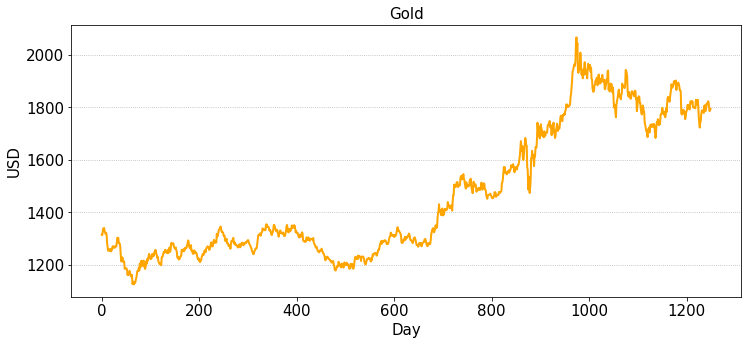

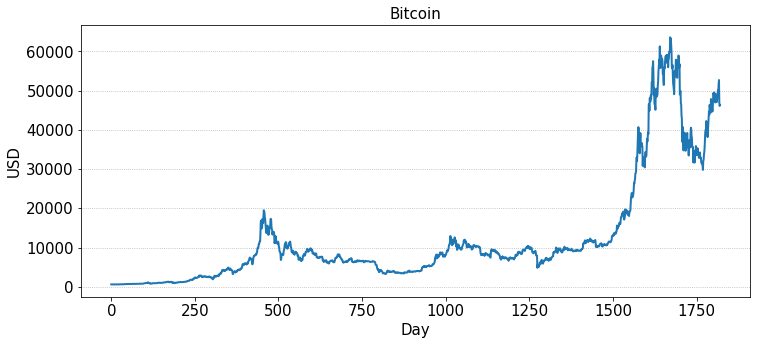

In [13]:
x1, y1 = init("./LBMA-GOLD.csv")
x2, y2 = init("./BCHAIN-MKPRU.csv")

fig = plt.figure(figsize=(12, 5))
plt.grid(b=True, axis='y', ls=':')
plt.plot(y1, linewidth=2, color="orange")
plt.title("Gold", fontsize=15)
plt.ylabel('USD', fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.legend(['real', 'prediction'], loc=2, fontsize=17)
plt.savefig("Gold.png")
plt.show()

fig = plt.figure(figsize=(12, 5))
plt.grid(b=True, axis='y', ls=':')
plt.plot(y2, linewidth=2)
plt.title("Bitcoin", fontsize=15)
plt.ylabel('USD', fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.legend(['real', 'prediction'], loc=2, fontsize=17)
plt.savefig("Bitcoin.png")
plt.show()